### Imports

In [1]:
from utils import *
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers, optimizers, losses
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

### Read/Preprocess Data

In [28]:
IMG_SIZE=224
X, y = read_images()

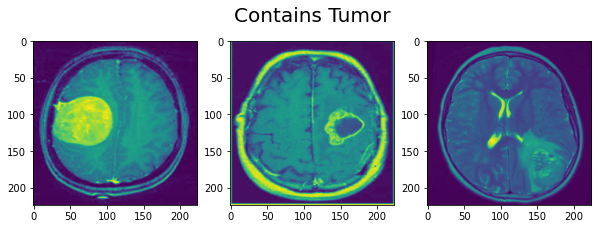

In [36]:
fig = plt.figure(figsize = (10,3.5))
plt.axis('off')
plt.title("Contains Tumor", fontsize=20)
ax = fig.add_subplot(1, 3, 1)
plt.imshow(X[0])
ax = fig.add_subplot(1, 3, 2)
plt.imshow(X[1])
ax = fig.add_subplot(1, 3, 3)
plt.imshow(X[2])

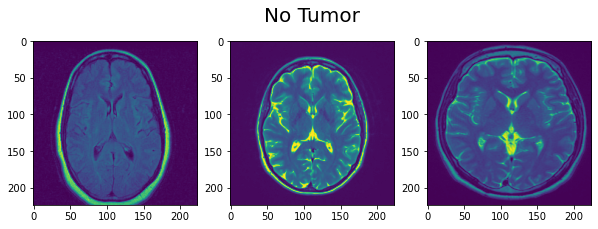

In [37]:
fig = plt.figure(figsize = (10,3.5))
plt.axis('off')
plt.title("No Tumor", fontsize=20)
ax = fig.add_subplot(1, 3, 1)
plt.imshow(X[-3])
ax = fig.add_subplot(1, 3, 2)
plt.imshow(X[-2])
ax = fig.add_subplot(1, 3, 3)
plt.imshow(X[-1])

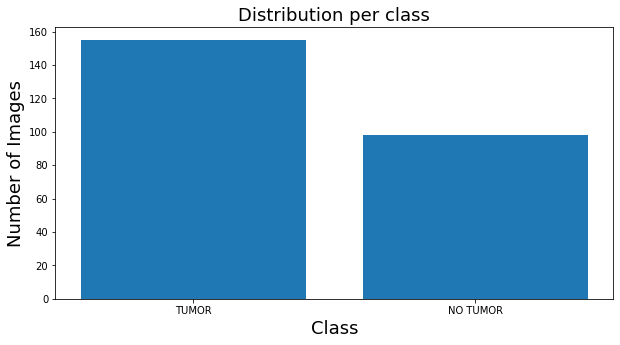

In [38]:
plt.figure(figsize = (10,5))
yes = len([label for label in y if label==1])
no = len([label for label in y if label==0])
plt.bar(["TUMOR", "NO TUMOR"], [yes,no])
plt.xlabel("Class", fontsize=18)
plt.ylabel("Number of Images", fontsize=18)
plt.title("Distribution per class", fontsize=18)
plt.show()

In [29]:
X = resize_and_rescale(X, IMG_SIZE=IMG_SIZE, rescale=False)
X_train, y_train, X_val, y_val, X_test, y_test = split_and_shuffle(X, y)

# convert to rgb images
X_train = np.array([[[[x,x,x]  for x in x2] for x2 in x1] for x1 in X_train])
X_val = np.array([[[[x,x,x]  for x in x2] for x2 in x1] for x1 in X_val])
X_test = np.array([[[[x,x,x]  for x in x2] for x2 in x1] for x1 in X_test])

### Model

In [20]:
def vgg16_model(learning_rate=0.00001):
    vgg16 = VGG16(include_top=False, weights="imagenet", input_shape = (IMG_SIZE,IMG_SIZE, 3))

    # prevent training of VGG16
    vgg16.trainable = False

    model = models.Sequential()
    model.add(vgg16)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(4096, activation="relu"))
    model.add(layers.Dense(4096, activation="relu"))
    model.add(layers.Dense(2, activation="sigmoid"))
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),
                  loss=losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    return model

In [32]:
model = vgg16_model()
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_18  (None, 512)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_18 (Dropout)        (None, 512)               0         
                                                                 
 dense_54 (Dense)            (None, 4096)              2101248   
                                                                 
 dense_55 (Dense)            (None, 4096)              16781312  
                                                                 
 dense_56 (Dense)            (None, 2)                 8194      
                                                     

### Validation and Testing

In [33]:
epochs = 13

results = model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=epochs)

Epoch 1/13
5/5 [==============================] - 28s 6s/step - loss: 0.8680 - accuracy: 0.6424 - val_loss: 1.0879 - val_accuracy: 0.6078
Epoch 2/13
5/5 [==============================] - 29s 6s/step - loss: 0.6702 - accuracy: 0.6954 - val_loss: 0.4794 - val_accuracy: 0.8039
Epoch 3/13
5/5 [==============================] - 30s 6s/step - loss: 0.5216 - accuracy: 0.7417 - val_loss: 0.4353 - val_accuracy: 0.7843
Epoch 4/13
5/5 [==============================] - 30s 6s/step - loss: 0.4141 - accuracy: 0.8079 - val_loss: 0.4466 - val_accuracy: 0.7843
Epoch 5/13
5/5 [==============================] - 30s 6s/step - loss: 0.4000 - accuracy: 0.8344 - val_loss: 0.3613 - val_accuracy: 0.8627
Epoch 6/13
5/5 [==============================] - 29s 6s/step - loss: 0.4019 - accuracy: 0.8609 - val_loss: 0.3370 - val_accuracy: 0.8824
Epoch 7/13
5/5 [==============================] - 30s 6s/step - loss: 0.3177 - accuracy: 0.8742 - val_loss: 0.3660 - val_accuracy: 0.8235
Epoch 8/13
5/5 [==================

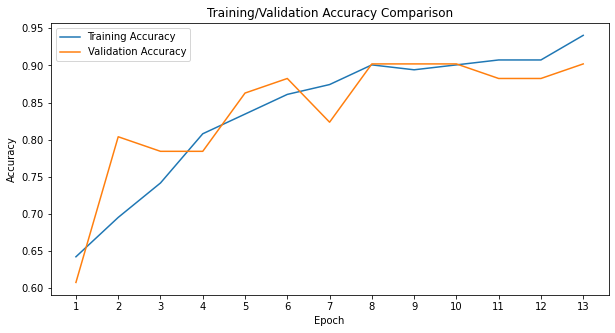

In [34]:
plot_accuracy_comparison([results.history["accuracy"], results.history["val_accuracy"]],
                        "Training/Validation Accuracy Comparison",
                        ["Training Accuracy", "Validation Accuracy"])

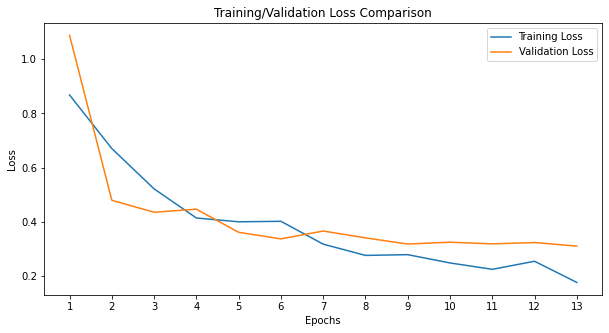

In [35]:
plot_loss_comparison([results.history["loss"], results.history["val_loss"]],
                     "Training/Validation Loss Comparison",
                     ["Training Loss", "Validation Loss"])

Epoch 1/13
7/7 [==============================] - 25s 3s/step - loss: 1.0522 - accuracy: 0.5099
Epoch 2/13
7/7 [==============================] - 28s 4s/step - loss: 0.6233 - accuracy: 0.6832
Epoch 3/13
7/7 [==============================] - 28s 4s/step - loss: 0.4699 - accuracy: 0.7871
Epoch 4/13
7/7 [==============================] - 28s 4s/step - loss: 0.4715 - accuracy: 0.8119
Epoch 5/13
7/7 [==============================] - 28s 4s/step - loss: 0.4285 - accuracy: 0.7723
Epoch 6/13
7/7 [==============================] - 28s 4s/step - loss: 0.3457 - accuracy: 0.8614
Epoch 7/13
7/7 [==============================] - 29s 4s/step - loss: 0.2971 - accuracy: 0.9059
Epoch 8/13
7/7 [==============================] - 29s 4s/step - loss: 0.2632 - accuracy: 0.8911
Epoch 9/13
7/7 [==============================] - 28s 4s/step - loss: 0.2857 - accuracy: 0.8861
Epoch 10/13
7/7 [==============================] - 29s 4s/step - loss: 0.2328 - accuracy: 0.9010
Epoch 11/13
7/7 [======================

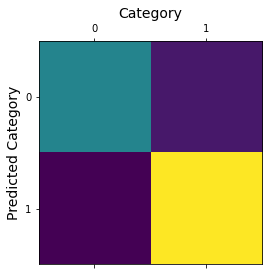

              precision    recall  f1-score   support

           0       0.83      0.94      0.88        16
           1       0.97      0.91      0.94        35

    accuracy                           0.92        51
   macro avg       0.90      0.93      0.91        51
weighted avg       0.93      0.92      0.92        51



In [30]:
epochs = 13

model = vgg16_model()
results = model.fit(np.concatenate((X_train,X_val)), np.concatenate((y_train,y_val)), epochs=epochs)
loss, acc = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", acc)

# show confusion matrix
y_pred=np.argmax(model.predict(X_test), axis=-1)
plot_confusion_matrix(y_test, y_pred)

# show other metrics
print(classification_report(y_pred,y_test))

### Hyper-Parameter Selection

#### Epochs

In [23]:
model = vgg16_model()
results = model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=30)

Epoch 1/30
5/5 [==============================] - 87s 18s/step - loss: 0.7676 - accuracy: 0.6026 - val_loss: 0.6364 - val_accuracy: 0.6667
Epoch 2/30
5/5 [==============================] - 84s 18s/step - loss: 0.5316 - accuracy: 0.7682 - val_loss: 0.5560 - val_accuracy: 0.7451
Epoch 3/30
5/5 [==============================] - 85s 18s/step - loss: 0.3881 - accuracy: 0.8079 - val_loss: 0.5133 - val_accuracy: 0.7843
Epoch 4/30
5/5 [==============================] - 86s 18s/step - loss: 0.3742 - accuracy: 0.8013 - val_loss: 0.4925 - val_accuracy: 0.7647
Epoch 5/30
5/5 [==============================] - 85s 18s/step - loss: 0.2998 - accuracy: 0.8742 - val_loss: 0.4924 - val_accuracy: 0.8235
Epoch 6/30
5/5 [==============================] - 84s 18s/step - loss: 0.2757 - accuracy: 0.8940 - val_loss: 0.4668 - val_accuracy: 0.8039
Epoch 7/30
5/5 [==============================] - 84s 18s/step - loss: 0.2663 - accuracy: 0.9007 - val_loss: 0.4832 - val_accuracy: 0.8627
Epoch 8/30
5/5 [===========

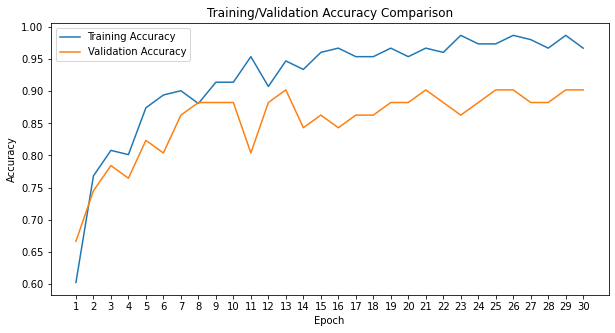

In [24]:
plot_accuracy_comparison([results.history["accuracy"], results.history["val_accuracy"]],
                        "Training/Validation Accuracy Comparison",
                        ["Training Accuracy", "Validation Accuracy"])

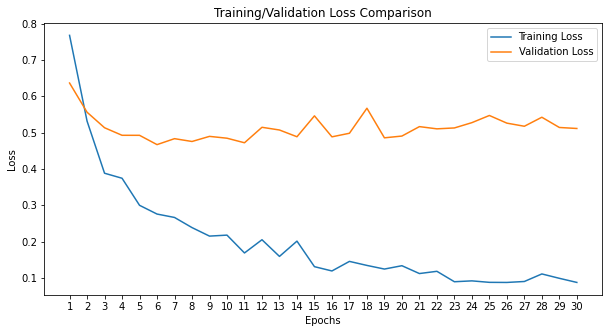

In [25]:
plot_loss_comparison([results.history["loss"], results.history["val_loss"]],
                     "Training/Validation Loss Comparison",
                     ["Training Loss", "Validation Loss"])

#### Learning Rate

In [17]:
#https://machinelearningmastery.com/learning-rate-for-deep-learning-neural-networks/
learning_rates=[0.1, 0.01, 0.001, 0.0001, 0.00001]
acc = []
loss = []

for lr in learning_rates:
    model = vgg16_model(learning_rate=lr)
    results = model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=epochs)

    acc.append(results.history["val_accuracy"])
    loss.append(results.history["val_loss"])

Epoch 1/15
5/5 [==============================] - 27s 6s/step - loss: 600520.1875 - accuracy: 0.5298 - val_loss: 5981.5376 - val_accuracy: 0.3725
Epoch 2/15
5/5 [==============================] - 29s 6s/step - loss: 4356.9707 - accuracy: 0.3775 - val_loss: 1205.2241 - val_accuracy: 0.6275
Epoch 3/15
5/5 [==============================] - 30s 6s/step - loss: 650.0019 - accuracy: 0.6225 - val_loss: 820.5844 - val_accuracy: 0.6275
Epoch 4/15
5/5 [==============================] - 30s 6s/step - loss: 502.9153 - accuracy: 0.6490 - val_loss: 509.7189 - val_accuracy: 0.6863
Epoch 5/15
5/5 [==============================] - 30s 6s/step - loss: 229.9550 - accuracy: 0.7483 - val_loss: 148.3693 - val_accuracy: 0.8235
Epoch 6/15
5/5 [==============================] - 30s 6s/step - loss: 42.3483 - accuracy: 0.8874 - val_loss: 62.5715 - val_accuracy: 0.9020
Epoch 7/15
5/5 [==============================] - 32s 7s/step - loss: 141.0580 - accuracy: 0.6887 - val_loss: 130.2211 - val_accuracy: 0.8039
Ep

Epoch 15/15
5/5 [==============================] - 27s 6s/step - loss: 0.0456 - accuracy: 0.9868 - val_loss: 0.8021 - val_accuracy: 0.8627
Epoch 1/15
5/5 [==============================] - 28s 6s/step - loss: 0.8979 - accuracy: 0.4768 - val_loss: 0.5188 - val_accuracy: 0.7451
Epoch 2/15
5/5 [==============================] - 27s 6s/step - loss: 0.5511 - accuracy: 0.7483 - val_loss: 0.3891 - val_accuracy: 0.8431
Epoch 3/15
5/5 [==============================] - 27s 6s/step - loss: 0.4412 - accuracy: 0.8146 - val_loss: 0.3605 - val_accuracy: 0.8824
Epoch 4/15
5/5 [==============================] - 28s 6s/step - loss: 0.3984 - accuracy: 0.8411 - val_loss: 0.3586 - val_accuracy: 0.8824
Epoch 5/15
5/5 [==============================] - 28s 6s/step - loss: 0.3109 - accuracy: 0.8675 - val_loss: 0.3242 - val_accuracy: 0.9020
Epoch 6/15
5/5 [==============================] - 27s 6s/step - loss: 0.3049 - accuracy: 0.8675 - val_loss: 0.3386 - val_accuracy: 0.9216
Epoch 7/15
5/5 [=================

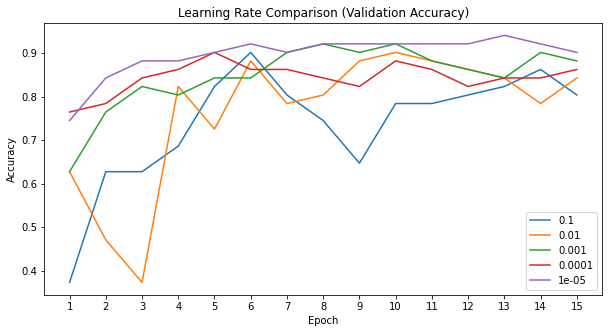

In [18]:
plot_accuracy_comparison(acc, "Learning Rate Comparison (Validation Accuracy)", learning_rates)

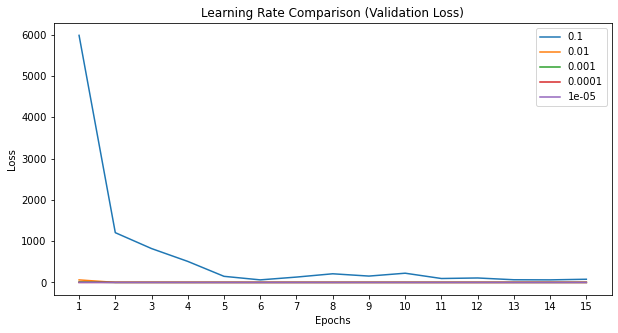

In [19]:
plot_loss_comparison(loss, "Learning Rate Comparison (Validation Loss)", learning_rates)